### Setup the environment
Upgrading SageMaker python SDK and TensorFlow to the current latest version. We need to restart the notebook's kernel to use the newly installed version. The following command will upgrade packages in your current kernel environment, which can affect other notebooks using the same kernel.

In [99]:
# import sys
# !{sys.executable} -m pip install --upgrade pip
# !{sys.executable} -m pip install --upgrade keras
# !{sys.executable} -m pip install --upgrade grpcio sagemaker==1.60.* awscli==1.* tensorflow==2.2.* tensorboard_plugin_profile==2.2.*

### Import the require libraries
Importing the required python libraries for the training to work.

In [124]:
import pandas as pd
import numpy as np
import boto3
import io

In [ ]:
### load data from s3 bucket

In [264]:
RAW_DATA_NO = 'Data/D1/raw'
BUCKET_NAME = 'ehr-model'
SWISS_DATASET = f"s3://{BUCKET_NAME}/{RAW_DATA_NO}/processedswitzerland.txt"
CLEVELAND_DATASET = f"s3://{BUCKET_NAME}/{RAW_DATA_NO}/processedcleveland.txt"
print(SWISS_DATASET)
print(CLEVELAND_DATASET)
# s3://ehr-model/Data/D1/raw/

s3://ehr-model/Data/D1/raw/processedswitzerland.txt
s3://ehr-model/Data/D1/raw/processedcleveland.txt


In [261]:
s3 = boto3.client('s3')
column_list = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num_label']

def load_data_s3(dataset):
    df = pd.read_csv(dataset,names=column_list).replace('?', np.nan)
    return df

def upload_file(file_name, bucket, object_name=None):
    """Upload a file to an S3 bucket

    :param file_name: File to upload
    :param bucket: Bucket to upload to
    :param object_name: S3 object name. If not specified then file_name is used
    :return: True if file was uploaded, else False
    """

    # If S3 object_name was not specified, use file_name
    if object_name is None:
        object_name = file_name

    # Upload the file
    s3_client = boto3.client('s3')
    try:
        response = s3_client.upload_file(file_name, bucket, object_name)
    except ClientError as e:
        logging.error(e)
        return False
    return True

In [127]:
df_swiss = load_data_s3(SWISS_DATASET)
df_cleve = load_data_s3(CLEVELAND_DATASET)
dataset = pd.concat([df_swiss, df_cleve], axis = 0) 

len(df_swiss),len(df_cleve),len(dataset)

(123, 303, 426)

In [128]:
dataset.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num_label
0,32.0,1.0,1.0,95,0.0,NaN,0,127,0,.7,1,NaN,NaN,1
1,34.0,1.0,4.0,115,0.0,NaN,NaN,154,0,.2,1,NaN,NaN,1
2,35.0,1.0,4.0,NaN,0.0,NaN,0,130,1,NaN,NaN,NaN,7,3
3,36.0,1.0,4.0,110,0.0,NaN,0,125,1,1,2,NaN,6,1
4,38.0,0.0,4.0,105,0.0,NaN,0,166,0,2.8,1,NaN,NaN,2


In [129]:
dataset.isna().sum()

age            0
sex            0
cp             0
trestbps       2
chol           0
fbs           75
restecg        1
thalach        1
exang          1
oldpeak        6
slope         17
ca           122
thal          54
num_label      0
dtype: int64

In [130]:
for x in column_list:
    print(x)
    print(dataset[x].unique())

age
[32. 34. 35. 36. 38. 40. 41. 42. 43. 45. 46. 47. 48. 50. 51. 52. 53. 54.
 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 72. 73.
 74. 37. 44. 49. 71. 39. 29. 77. 76.]
sex
[1. 0.]
cp
[1. 4. 3. 2.]
trestbps
['95' '115' nan '110' '105' '100' '135' '150' '125' '145' '140' '155'
 '160' '120' '130' '165' '80' '180' '170' '200' '185' 145.0 160.0 120.0
 130.0 140.0 172.0 150.0 110.0 132.0 117.0 135.0 112.0 105.0 124.0 125.0
 142.0 128.0 170.0 155.0 104.0 180.0 138.0 108.0 134.0 122.0 115.0 118.0
 100.0 200.0 94.0 165.0 102.0 152.0 101.0 126.0 174.0 148.0 178.0 158.0
 192.0 129.0 144.0 123.0 136.0 146.0 106.0 156.0 154.0 114.0 164.0]
chol
[  0. 233. 286. 229. 250. 204. 236. 268. 354. 254. 203. 192. 294. 256.
 263. 199. 168. 239. 275. 266. 211. 283. 284. 224. 206. 219. 340. 226.
 247. 167. 230. 335. 234. 177. 276. 353. 243. 225. 302. 212. 330. 175.
 417. 197. 198. 290. 253. 172. 273. 213. 305. 216. 304. 188. 282. 185.
 232. 326. 231. 269. 267. 248. 360. 258. 308. 245. 270. 2

In [131]:
feature=['sex',  'age', 'trestbps', 'thalach' ]

In [132]:
data_feature=dataset[feature]


In [133]:
data_feature.isna().sum()

sex         0
age         0
trestbps    2
thalach     1
dtype: int64

In [134]:
dataset_drop=data_feature.dropna()
len(data_feature)

426

In [135]:
dataset_drop.head()

,sex,age,trestbps,thalach
0,1.0,32.0,95,127
1,1.0,34.0,115,154
3,1.0,36.0,110,125
4,0.0,38.0,105,166
5,0.0,38.0,110,156


In [136]:
dataset_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 424 entries, 0 to 302
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sex       424 non-null    float64
 1   age       424 non-null    float64
 2   trestbps  424 non-null    object 
 3   thalach   424 non-null    object 
dtypes: float64(2), object(2)
memory usage: 16.6+ KB


In [137]:
#all numbers are don't have fraction
for x in dataset_drop.columns:
    print(x)
    print(dataset_drop[x].unique())


sex
[1. 0.]
age
[32. 34. 36. 38. 40. 41. 42. 43. 45. 46. 47. 48. 50. 51. 52. 53. 54. 55.
 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 72. 73. 74.
 37. 44. 49. 71. 39. 35. 29. 77. 76.]
trestbps
['95' '115' '110' '105' '100' '135' '150' '125' '145' '140' '155' '160'
 '120' '130' '165' '80' '180' '170' '200' '185' 145.0 160.0 120.0 130.0
 140.0 172.0 150.0 110.0 132.0 117.0 135.0 112.0 105.0 124.0 125.0 142.0
 128.0 170.0 155.0 104.0 180.0 138.0 108.0 134.0 122.0 115.0 118.0 100.0
 200.0 94.0 165.0 102.0 152.0 101.0 126.0 174.0 148.0 178.0 158.0 192.0
 129.0 144.0 123.0 136.0 146.0 106.0 156.0 154.0 114.0 164.0]
thalach
['127' '154' '125' '166' '156' '179' '128' '150' '120' '144' '176' '99'
 '122' '145' '140' '138' '133' '113' '118' '149' '124' '110' '139' '92'
 '104' '170' '163' '60' '126' '82' '95' '115' '135' '141' '155' '83' '97'
 '98' '100' '148' '103' '121' '131' '182' '105' '175' '94' '119' '143'
 '130' '63' '70' '77' '117' '123' '134' '72' '78' '109' '86' '114' '93

In [138]:
for x in dataset_drop.columns:
    dataset_drop[x] = dataset_drop[x].astype(int)

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [139]:
dataset_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 424 entries, 0 to 302
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   sex       424 non-null    int64
 1   age       424 non-null    int64
 2   trestbps  424 non-null    int64
 3   thalach   424 non-null    int64
dtypes: int64(4)
memory usage: 16.6 KB


In [146]:
# dataset_drop.to_csv("process.csv",index=False)


In [267]:
FILE_NAME= "process.csv"
UPLOAD_PROCESS_DATA = f"Data/D1/processes/{FILE_NAME}"
upload_file(FILE_NAME,BUCKET_NAME,UPLOAD_PROCESS_DATA)

True

### Training mode on Local

In [1]:

import pandas as pd
import numpy as np
processed_data= pd.read_csv("process.csv")


In [2]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [14]:
X_feature = processed_data[['sex','age','thalach']]
y_feature =  processed_data['trestbps']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_feature, y_feature, test_size=0.15, random_state=42)
print(f" Total Train: {len(X_train)} \n Total Test: {len(X_test)} ")

 Total Train: 360 
 Total Test: 64 


In [4]:
X_train_scaler=scaler.fit_transform(X_train)
X_test_scaler=scaler.fit_transform(X_test)
y_train_scaler=scaler.fit_transform(np.array(y_train).reshape(1,-1)).reshape(-1,1)
y_test_scaler=scaler.fit_transform(np.array(y_test).reshape(1,-1)).reshape(-1,1)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

In [ ]:

call_back=[
    ModelCheckpoint(monitor='val_loss',
                    filepath=f'chkpoint_best_weights.hdf5',
                    save_best_only=True,
                    save_weights_only=True),
    
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200),
#     # tensor board callback.
#     TensorBoard(log_dir=logs_dir)
]

model = Sequential()
model.add(Dense(128, activation="relu", input_dim=3))
model.add(Dense(32, activation="relu"))
Dropout(0.1)
model.add(Dense(8, activation="relu"))
model.add(Dense(1, activation="linear"))

# Compile model: The model is initialized with the Adam optimizer and then it is compiled.
model.compile(loss='mean_squared_error', optimizer=Adam(lr=1e-3, decay=1e-3 / 200))

# Patient early stopping
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

# Fit the model
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=500, 
                    batch_size=64, 
                    verbose=2, 
                    callbacks=[call_back])


In [30]:
losses = pd.DataFrame(model.history.history)

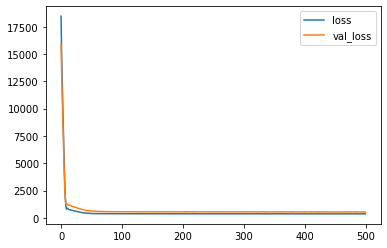

In [31]:
losses.plot()

In [32]:
pred=model.predict(X_test)
pred[:5]

array([[136.15419],
       [153.16505],
       [138.48212],
       [137.57887],
       [151.22513]], dtype=float32)

#### Evaluation

In [27]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [40]:
print(mean_absolute_error(y_test,pred))
np.sqrt(mean_squared_error(y_test,pred))

16.009822114330746


21.15596926655589

In [36]:
y_test[:5].values , pred[:5]

(array([130, 118, 130, 128, 144]),
 array([136.88078449, 141.87756393, 138.46609243, 137.34911706,
        140.00012635]))